In [6]:
import Pkg
Pkg.activate("../../Tasks2D")

  Activating project at `~/Developer/research/summer2023/tasks2d/Tasks2D`


In [7]:
using Revise

In [8]:
using Plots

In [9]:
import LineWorlds
const L = LineWorlds

LineWorlds

In [11]:
import GenPOMDPs
using Gen

[ Info: Precompiling GenPOMDPs [f88df91c-fa0e-46d7-b73d-4420684e5acb]


In [10]:
_segs, _boxes, _bb, _center, _xs, _hds, _ps, _dxs, _dhds, _us, _T = L.load_env();

In [140]:
PARAMS = (;
    map = _segs,
    orientation = π/2,
    bounding_box = L.bounding_box(_segs),
    step = (; σ = 0.2),
    obs = (;
        fov = 2π,
        n_rays = 40,
        sensor_args = (;
            w            = 5,
            s_noise      = 0.2,
            outlier      = 0.1,
            outlier_vol = 100.0,
            zmax = 100.0
        )
    )
);

In [117]:
mvuniform = L.ProductDistribution(uniform);
@gen (static) function uniform_agent_pos(params)
    w = params.map # a map, represented as list of line segments
    
    mins, maxs = PARAMS.bounding_box
    pos ~ mvuniform(mins, maxs)
    
    return pos
end
@load_generated_functions()

In [118]:
pos0 = uniform_agent_pos(PARAMS)

2-element Vector{Float64}:
  7.8954853174358535
 11.716227579478984

In [119]:
# The next position, under a 0-noise model, with no walls.
function det_next_pos((x, y), a)
    a == :up    ? [x, y + 1] :
    a == :down  ? [x, y - 1] : 
    a == :left  ? [x - 1, y] :
    a == :right ? [x + 1, y] :
    a == :stay  ? [x, y]     :
                error("Unrecognized action: $a")
end

# Given the old pos and a new pose the agent would move to
# in absense of walls -- find where the agent did move to,
# given that it can't pass through walls.
# Specificallly -- if the agent would have to pass
# through a wall to do this, don't move it.
# [TODO: have the agent move to the intersection point
# if it tries to go through a wall.]
function handle_wall_intersection(prev, new, walls)
    move = L.Segment(prev, new)
    for wall in walls
        do_intersect, dist = L.Geometry.cast(move, wall)
        if do_intersect && dist ≤ L.Geometry.norm(move)
            return prev
        end
    end
    return new
end

@gen (static) function motion_model(prev_pos, action, PARAMS)
    np = det_next_pos(prev_pos, action)
    noisy_next_pos ~ broadcasted_normal(np, PARAMS.step.σ)
    
    next_pos = handle_wall_intersection(prev_pos, noisy_next_pos, PARAMS.map)
    
    return next_pos
end
@load_generated_functions()

In [120]:
tr = simulate(motion_model, (pos0, :left, PARAMS));
get_choices(tr)

│
└── :noisy_next_pos : [7.283307997276232, 12.027645409805594]


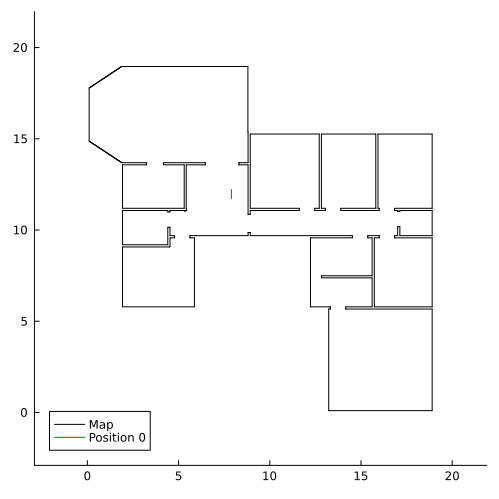

In [121]:
mypl = plot(size=(500,500), aspect_ratio=:equal, grid=false,
xlim=(_bb[1][1]-3, _bb[2][1]+3),
ylim=(_bb[1][2]-3, _bb[2][2]+3),
legend=:bottomleft,
)
plot!(_segs, c=:black, linewidth=1, label="Map")
plot!(L.Pose(pos0, PARAMS.orientation), c=:green, label="Position 0")

In [155]:
### Observation Model ###

gm             = HomogeneousMixture(L.diagnormal, [1, 1])
outlier_dist   = L.diagnormal
sensor_mix     = HeterogeneousMixture([gm, outlier_dist])
sensor_product = L.ProductDistribution(sensor_mix)

@gen function sensor_model(pos, params)
    p = L.Pose(pos, params.orientation)
    
    w, s_noise, outlier, outlier_vol, zmax = params.obs.sensor_args
    
    segs = L.stack(Vector.(params.map))
    _as = L.create_angles(params.obs.fov, params.obs.n_rays)
    zs = reshape(L.cast(Vector(p), _as, segs)[1], (1, :))
    ỹ  = L.get_2d_mixture_components(zs, _as, w)[1,:,:,:]
    
    # Observe a list of points, in the agent's coordinate frame.
    obs ~ L.sensordist_2dp3(ỹ, s_noise, outlier, outlier_vol)  
    
    return obs
end;
@load_generated_functions

In [160]:
obspts = sensor_model(pos0, PARAMS);

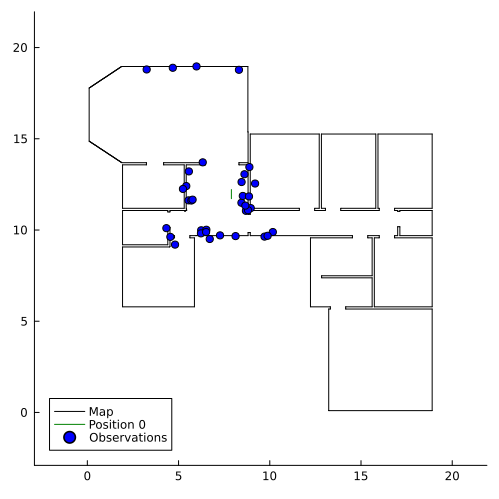

In [163]:
mypl = plot(size=(500,500), aspect_ratio=:equal, grid=false,
xlim=(_bb[1][1]-3, _bb[2][1]+3),
ylim=(_bb[1][2]-3, _bb[2][2]+3),
legend=:bottomleft,
)
plot!(_segs, c=:black, linewidth=1, label="Map")
plot!(L.Pose(pos0, PARAMS.orientation), c=:green, label="Position 0")
scatter!(obspts.*L.Pose(pos0, PARAMS.orientation), c=:blue, label="Observations")

In [164]:
# POMDP of this environment
pomdp = GenPOMDPs.GenPOMDP(
    uniform_agent_pos,       # INIT   : params                      ⇝ state
    motion_model,            # STEP   : prev_state, actions, params ⇝ state
    sensor_model,            # OBS    : state, params               ⇝ observation
    (state, action) -> 0.    # UTILITY: state, action, params       → utility
)

GenPOMDPs.GenPOMDP(var"##StaticGenFunction_uniform_agent_pos#561"(Dict{Symbol, Any}(), Dict{Symbol, Any}()), var"##StaticGenFunction_motion_model#584"(Dict{Symbol, Any}(), Dict{Symbol, Any}()), DynamicDSLFunction{Any}(Dict{Symbol, Any}(), Dict{Symbol, Any}(), Type[Any, Any], false, Union{Nothing, Some{Any}}[nothing, nothing], var"##sensor_model#1053", Bool[0, 0], false), var"#402#403"())

In [165]:
# Generative function over trajectories of the POMDP,
# given a fixed action sequence.
trajectory_model = GenPOMDPs.ControlledTrajectoryModel(pomdp)

GenPOMDPs.var"##StaticGenFunction__ControlledTrajectoryModel#1123"(Dict{Symbol, Any}(), Dict{Symbol, Any}())

In [166]:
@load_generated_functions()

In [187]:
a = (x=1, b=2)
c = (a..., x=3)

(x = 3, b = 2)

In [227]:
tr = generate(trajectory_model, (
        15,
        [
            :down, :down,
            :right, :right,
            :down, :down, :down, :down,
            :down, :right, :right, :right, :right,
            :down, :down, :right, :right
        ],
        (PARAMS..., obs=(
                PARAMS.obs...,
                sensor_args = (;
                    w            = 5,
                    s_noise      = 0.01,
                    outlier      = 0.000001,
                    outlier_vol = 100.0,
                    zmax = 100.0
                ),
                n_rays=360
            )
        )
    ), choicemap((GenPOMDPs.state_addr(0, :pos), [5., 17.]))
)[1];

In [228]:
poses = [
    L.Pose(position, PARAMS.orientation)
    for position in GenPOMDPs.state_sequence(tr)
];
ptclouds = [
    obss[:obs].*pose
    for (obss, pose) in zip(
        GenPOMDPs.observation_sequence(tr),
        poses
    )
];

[ Info: Saved animation to /Users/georgematheos/Developer/research/summer2023/tasks2d/notebooks_messy/lineworld/tmp.gif


Plots.AnimatedGif("/Users/georgematheos/Developer/research/summer2023/tasks2d/notebooks_messy/lineworld/tmp.gif")
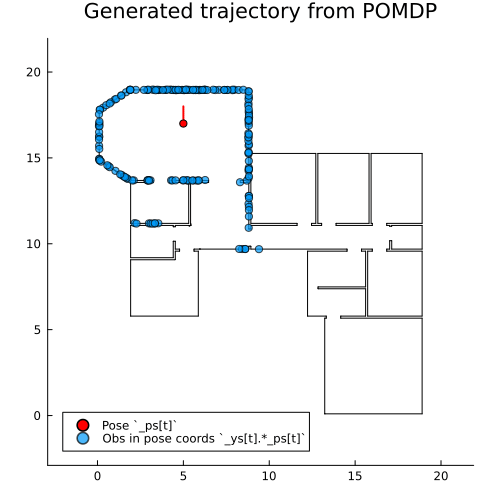

In [229]:
using Random
# -----------------------
col = palette(:default)
ani = Animation()
for t=1:1:length(poses)
    p = poses[t]
    y = ptclouds[t]

    agent_plt = plot(
        size=(500,500), aspect_ratio=:equal, title="Generated trajectory from POMDP", grid=false,
        xlim=(_bb[1][1]-3, _bb[2][1]+3),
        ylim=(_bb[1][2]-3, _bb[2][2]+3),
        legend=:bottomleft,
    )
    plot!(_segs, c=:black, linewidth=1, label=nothing)
    plot!([p], c=:red, r=1.0, linewidth=2, label=nothing)
    scatter!([p.x], c=:red, label="Pose `_ps[t]`")
    scatter!(Random.shuffle(y[1:2:end]), c=col[1], markersize=4, alpha=.7, markerstrokewidth=1, label="Obs in pose coords `_ys[t].*_ps[t]`")

    frame(ani, agent_plt)
end
# gif(ani, "_imgs/loc_data_gen.gif", fps=2) # gif(ani, fname, fps=10)
gif(ani, fps=3)

[ Info: Saved animation to /Users/georgematheos/Developer/research/summer2023/tasks2d/notebooks_messy/lineworld/tmp.gif


Plots.AnimatedGif("/Users/georgematheos/Developer/research/summer2023/tasks2d/notebooks_messy/lineworld/tmp.gif")
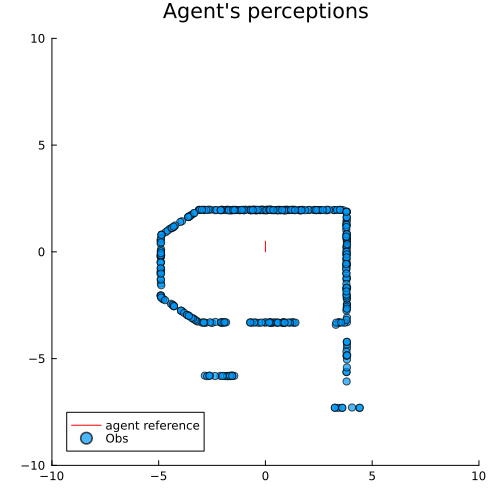

In [232]:
using Random
# -----------------------
col = palette(:default)
ani = Animation()
for t=1:1:length(poses)
    p = poses[t]

    agent_plt = plot(
        size=(500,500), aspect_ratio=:equal, title="Agent's perceptions", grid=false,
        xlim=(-10, 10),
        ylim=(-10, 10),
        legend=:bottomleft,
    )
    plot!(L.Pose([0, 0], π/2), c=:red, label="agent reference")
    scatter!(Random.shuffle(
            GenPOMDPs.observation_sequence(tr)[t][:obs][1:1:end] .* L.Pose([0, 0], π/2)
        ), c=col[1], markersize=4, alpha=.7, markerstrokewidth=1, label="Obs")

    frame(ani, agent_plt)
end
# gif(ani, "_imgs/loc_data_gen.gif", fps=2) # gif(ani, fname, fps=10)
gif(ani, fps=3)